# Importações

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 18.3 MB/s eta 0:00:00


In [ ]:
!pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import numpy as np

# Inicialização do ambiente

In [ ]:
DONOTHING = 0
MATCH = 1

In [ ]:
INCLUDING_NUMBER = 1

In [ ]:
class Marriage(gym.Env):
  def __init__(self, df_term_path, df_buy_path):
    # Espaços de ação e ambiente
    self.action_space = spaces.Discrete(2)
    self.observation_space = spaces.Box(low=0.0, high=100000.0, shape=(len([
        'current_buy_order_price',
        'current_ideal_price'
    ]),), dtype=np.float64)

    self.df_term = pd.read_csv(df_term_path) # <- tabela de termos usada é a recebida nos parâmetros
    self.df_buy = pd.read_csv(df_buy_path)
    self.df_buy_output = self.df_buy
    self.current_term_index = -1
    self.terminate_all = False
    self.current_cdi = 1.0
    self.df_term_lines_count = len(self.df_term) # Contagem de linhas na tabela à termo para iteração no loop externo
    self.matchs = []


  """
    O método reset() é chamado no início de cada episódio. Um episódio, nesse modelo, se caracteriza pela
    completude de um casamento de UMA ação à termo.
    No início de cada episódio, há a criação de um novo dataframe contendo apenas ações à vista, que é armazenado
    como o atributo self.filtered_buy_orders_table.
    As ações à vista inseridas são as que podem ser casadas com a ação à termo atual. A ação à termo
    atual é selecionada com o índice dela na tabela df_term. As ações à vista inseridas têm que ter mesmo(a):
    - cliente na coluna 'Cód. Cliente'
    - data na coluna 'Dt. Operação'
    - ativo na coluna 'Cód. Título'
    - corretora na coluna 'Cód. Corretora'
  """
  def reset(self, seed=None, return_info=False, options=None):
    if seed is not None:
      np.random.seed(seed)
    self.current_term_index += 1
    self.current_term_key = self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('Chave')]
    print("=========================== EPISODE Nº " + str(self.current_term_index) + "===========================")
    if self.current_term_index >= len(self.df_term):
      self.terminate_all = True
      return np.array([self.current_buy_order_price, self.current_ideal_price]), {}
    else:
      current_term_client = self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('Cód. Cliente')]
      current_term_operation_date = self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('Dt. Operação')]
      current_term_title_code = self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('Cód. Título')]
      current_term_broker_code = self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('Cód. Corretora')]
      self.filtered_buy_orders_table = self.filter_and_order(
          self.df_buy,
          current_term_client,
          current_term_operation_date,
          current_term_title_code,
          current_term_broker_code)
      self.filtered_buy_orders_table_output = self.filter_and_order_output(
          self.df_buy_output,
          current_term_client,
          current_term_operation_date,
          current_term_title_code,
          current_term_broker_code)

      # Cópia da tabela de compras filtrada, para que seja possível exibir no output sem afetar a lógica desenvolvida
      self.filtered_buy_orders_table_qtd_frozen = self.filtered_buy_orders_table_output
      print(self.filtered_buy_orders_table_qtd_frozen)

      # Atualização dos atributos correspondentes às variávei de ambiente
      self.current_buy_order_price = self.filtered_buy_orders_table.iloc[0, self.filtered_buy_orders_table.columns.get_loc('Preço')] # índice 0 da tabela de compra filtrada (linha 0)
      self.current_ideal_price = self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('preco_ideal_compra')]

      # Atualização dos demais atributos
      self.current_buy_index_from_filtered_table = 0
      self.current_term_order_price = self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('Preço')]
      self.current_term_order_quantity = self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('Quantidade')]
      # A atualização concreta dos seguintes atributos será feita após uma ação à vista ser selecionada no método step():
      self.current_buy_order_quantity = 0.0
      self.distance_from_ideal_price = 0.0
      self.current_cdi = 1.0
      self.included_buy_orders_price_array = []
      self.current_selected_buy_orders_quantity = 0

      return np.array([self.current_buy_order_price, self.current_ideal_price]), {}


  """
    A cada ação que o agente toma, o método step() é chamado. Ele é responsável por tratar
    o ambiente (espaço observável) de acordo com a ação que foi escolhida. Existem apenas duas
    ações que o agente pode escolher nesse modelo:
    - DONOTHING = 0
    - MATCH = 1
    A cada match, o agente irá incluir apenas uma unidade da ação à vista atual. Ao fazer isso,
    a quantidade dessa ação irá diminuir em 1 nas tabelas df_buy e filtered_buy_orders_table,
    também tratadas como atributos da classe. Além da mudança do estado observável, o método step()
    também calcula a recompensa a ser recebida pelo agente e checa se o estado é terminal ou não.
    Isso é feito por meio dos métodos calculate_reward() e is_terminal_state().
    A iteração na tabela de ações à vista disponíveis acontece da seguinte forma: se a ação do
    agente é MATCH, o índice da ação à vista selecionada não muda. Se a ação do agente é DONOTHING,
    o índice da ação à vista selecionada muda para +1.
  """
  def step(self, action):
    # Se a linha atual tem quantidade 0, ação do agente passa a ser DONOTHING e passa para a próxima linha
    if self.filtered_buy_orders_table.iloc[self.current_buy_index_from_filtered_table, self.filtered_buy_orders_table.columns.get_loc('Quantidade')] == 0:
      action == DONOTHING
    if self.terminate_all == True:
      return [self.current_buy_order_price, self.current_ideal_price], 0, False, False, {}
    if action == MATCH:
      # Mudança da quantidade em filtered_buy_orders_table
      self.filtered_buy_orders_table.iloc[self.current_buy_index_from_filtered_table, self.filtered_buy_orders_table.columns.get_loc('Quantidade')] -= INCLUDING_NUMBER
      # Pegar o índice da ação à vista atual DA TABELA self.df_buy
      index_from_df_buy = self.filtered_buy_orders_table.iloc[self.current_buy_index_from_filtered_table, self.filtered_buy_orders_table.columns.get_loc('index_from_df_buy')]
      # Armazena o valor da quantidade total daquela ação à vista
      self.total_current_buy_qqt = self.df_buy.iloc[index_from_df_buy, self.df_buy.columns.get_loc('Quantidade')]
      # Mudança da quantidade na tabela à vista self.df_buy
      self.df_buy.iloc[index_from_df_buy, self.df_buy.columns.get_loc('Quantidade')] -= INCLUDING_NUMBER

      # Adicionar preço da ação à vista atual no array self.included_buy_orders_price_array
      self.included_buy_orders_price_array.append(self.filtered_buy_orders_table.iloc[self.current_buy_index_from_filtered_table, self.filtered_buy_orders_table.columns.get_loc('Preço')])
      # Calcular o cdi atual pelo método calculate_current_cdi
      self.current_cdi = self.calculate_current_cdi()
      self.current_selected_buy_orders_quantity += INCLUDING_NUMBER # adiciona uma unidade no atributo self.current_selected_buy_orders_quantity
      observation = np.array([self.current_buy_order_price, self.current_ideal_price])
      reward = self.calculate_reward(action)
      terminated = self.is_terminal_state()

      if self.included_buy_orders_price_array != []:
        self.matchs.append([self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('Chave')],
                          self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('Cód. Cliente')],
                          self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('Dt. Operação')],
                          self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('Cód. Título')],
                          self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('Cód. Corretora')],
                          self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('Vencimento')],
                          self.current_cdi,
                          self.current_selected_buy_orders_quantity,
                          self.filtered_buy_orders_table_qtd_frozen.iloc[self.current_buy_index_from_filtered_table, self.filtered_buy_orders_table_qtd_frozen.columns.get_loc('Quantidade')],
                          sum(self.included_buy_orders_price_array) / len(self.included_buy_orders_price_array),
                          ])

    elif action == DONOTHING:
      reward = self.calculate_reward(action)
      terminated = self.is_terminal_state()
      # Iterar no índice de current_buy_index_from_filtered_table (handle de quando a tabela acabar, começar do início)
      if self.current_buy_index_from_filtered_table + 1 == len(self.filtered_buy_orders_table):
        self.current_buy_index_from_filtered_table = 0
      else:
        self.current_buy_index_from_filtered_table += 1
      self.current_buy_order_price = self.filtered_buy_orders_table.iloc[self.current_buy_index_from_filtered_table, self.filtered_buy_orders_table.columns.get_loc('Preço')] # Pega o preço da ação à vista atual
      observation = np.array([self.current_buy_order_price, self.current_ideal_price])
    info = {}

    return observation, reward, terminated, False, info # observation_space, reward, bool if is terminated


  """
    A seguir, estão os métodos auxiliares para o ambiente. São métodos chamados a cada
    ação tomada pelo agente, ou seja, a cada chamada do método step().
  """
  def calculate_current_cdi(self):
    # Média dos preços de todas as ações à vista já casadas
    mean = sum(self.included_buy_orders_price_array) / len(self.included_buy_orders_price_array)
    rent = (self.current_term_order_price / mean) - 1
    du = self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('dias_uteis')]
    rent_anual = round(((1 + rent)**(252/du)) - 1, 5)
    di = self.df_term.iloc[self.current_term_index, self.df_term.columns.get_loc('DI')]
    cdi = round(rent_anual/di, 5)
    return cdi


  """
    A função de recompensa foi feita de tal maneira que, o quanto menor a distância do preço
    ideal, maior será a recompensa. Isso pode ser alcançado por meio de uma simples função
    f(x) = 0.1/x. Se a distância do preço ideal for 0, a recompensa retornada será 100.
  """
  def calculate_reward(self, action):
    if action == DONOTHING:
      return 0
    elif action == MATCH:
      distance_from_ideal_price = self.distance_from_ideal_price_calculator()
      if distance_from_ideal_price <= 0.1:
        return 100
      else:
        return 0.1/distance_from_ideal_price


  """
    A distância do preço ideal é dada pelo módulo da diferença entre preço ideal e
    o preço da ação à vista atual (ação à vista que o agente está "observando").
    O preço ideal é aquele que, se todas as ações à vista incluídas no casamento tiverem,
    a rentabilidade em relação ao DI é de 100%. Dito isso, o quanto mais próximo do preço
    ideal o agente escolher, melhor.
  """
  def distance_from_ideal_price_calculator(self):
    distance_from_ideal_price = abs(self.current_buy_order_price - self.current_ideal_price)
    return distance_from_ideal_price


  """
    O estado é considerado terminal se e somente se a quantidade de ações à vista selecionadas
    para casamento for igual à quantidade requerida pelo termo atual "observado".
  """
  def is_terminal_state(self):
    if self.current_selected_buy_orders_quantity == self.current_term_order_quantity: # Atributos atualizados nos métodos step() e reset(), respectivamente
      return True
    else:
      return False


  """
    filter data from buy table
  """
  def filter_and_order(self, buy_table_df, current_term_client, current_term_operation_date, current_term_title_code, current_term_broker_code):
    # Colunas do dataframe contendo as ações à vista filtradas, menos 'index_from_df_buy' porque vamos adicioná-la depois
    columns = ['Cód. Cliente', 'Dt. Operação', 'Tipo Operação', 'Cód. Título', 'Cód. Corretora', 'Quantidade', 'Preço', 'Valor Líquido', 'Vencimento', 'Tipo']

    # Filtrar as ordens baseadas nos critérios fornecidos
    mask = (buy_table_df['Cód. Cliente'] == current_term_client) & \
           (buy_table_df['Dt. Operação'] == current_term_operation_date) & \
           (buy_table_df['Cód. Título'] == current_term_title_code) & \
           (buy_table_df['Cód. Corretora'] == current_term_broker_code)

    # Aplicar a máscara para filtrar as linhas
    filtered_orders = buy_table_df[mask].copy()

    # Adicionar o índice de cada linha filtrada na coluna 'index_from_df_buy'
    filtered_orders['index_from_df_buy'] = filtered_orders.index

    # Reorganizar as colunas para incluir 'index_from_df_buy'
    filtered_buy_orders_table = filtered_orders[columns + ['index_from_df_buy']]

    return filtered_buy_orders_table

  def filter_and_order_output(self, buy_table_df_output, current_term_client, current_term_operation_date, current_term_title_code, current_term_broker_code):
    # Colunas do dataframe contendo as ações à vista filtradas, menos 'index_from_df_buy' porque vamos adicioná-la depois
    columns = ['Cód. Cliente', 'Dt. Operação', 'Tipo Operação', 'Cód. Título', 'Cód. Corretora', 'Quantidade', 'Preço', 'Valor Líquido', 'Vencimento', 'Tipo']

    # Filtrar as ordens baseadas nos critérios fornecidos
    mask = (buy_table_df_output['Cód. Cliente'] == current_term_client) & \
           (buy_table_df_output['Dt. Operação'] == current_term_operation_date) & \
           (buy_table_df_output['Cód. Título'] == current_term_title_code) & \
           (buy_table_df_output['Cód. Corretora'] == current_term_broker_code)

    # Aplicar a máscara para filtrar as linhas
    filtered_orders_output = buy_table_df_output[mask].copy()

    # Adicionar o índice de cada linha filtrada na coluna 'index_from_df_buy'
    filtered_orders_output['index_from_df_buy'] = filtered_orders_output.index

    # Reorganizar as colunas para incluir 'index_from_df_buy'
    filtered_buy_orders_table_output = filtered_orders_output[columns + ['index_from_df_buy']]

    return filtered_buy_orders_table_output

  """
    Os métodos a seguigr são necessários para passar no teste de checagem de ambiente
  """

  def render(self):
    pass

  def close(self):
    pass

# Checagem do ambiente


In [ ]:
df_term_PATH = '/content/drive/Shareddrives/grupo4/dados_ordenados_data/df_venda.csv'
df_buy_PATH = '/content/drive/Shareddrives/grupo4/dados_ordenados_data/df_compra.csv'
df_teste10termos = '/content/drive/Shareddrives/grupo4/dados_curtos/df_teste10termos.csv' #198.509 ações a termo

df_term_SHORT_PATH = '/content/drive/Shareddrives/grupo4/dados_curtos/df_venda_.csv'

In [ ]:
from stable_baselines3.common.env_checker import check_env
env = Marriage(df_teste10termos, df_buy_PATH)
check_env(env)

=========================== EPISODE Nº 0===========================
    Cód. Cliente Dt. Operação Tipo Operação Cód. Título Cód. Corretora  \
384  Cliente 100   2022-02-02             C       LPSB3           PLAN   
930  Cliente 100   2022-02-02             C       LPSB3           PLAN   
932  Cliente 100   2022-02-02             C       LPSB3           PLAN   
933  Cliente 100   2022-02-02             C       LPSB3           PLAN   
934  Cliente 100   2022-02-02             C       LPSB3           PLAN   
935  Cliente 100   2022-02-02             C       LPSB3           PLAN   
936  Cliente 100   2022-02-02             C       LPSB3           PLAN   
937  Cliente 100   2022-02-02             C       LPSB3           PLAN   
939  Cliente 100   2022-02-02             C       LPSB3           PLAN   
946  Cliente 100   2022-02-02             C       LPSB3           PLAN   
947  Cliente 100   2022-02-02             C       LPSB3           PLAN   
962  Cliente 100   2022-02-02             C 

# DQN


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
# agent

class DQNA:
    def __init__(self, state_size, action_size):
        self.n_actions = action_size

        self.lr = 0.001 # taxa de aprendizado
        self.gamma = 0.99 # fator de desconto
        self.exploration_proba = 1.0 # probabilidade de exploração
        self.exploration_proba_decay = 0.005 # taxa de decaimento
        self.batch_size = 32 # número de experiências para treinar o DQN

        self.memory_buffer= list() # buffer de experiências
        self.max_memory_buffer = 2000 # número máximo de experiências

        # Modelo de rede neural
        self.model = Sequential([
            Dense(units=24, input_dim=state_size, activation='relu'),
            Dense(units=24, activation='relu'),
            Dense(units=action_size, activation='linear')
        ])
        self.model.compile(loss="mse", optimizer=Adam(learning_rate=self.lr))

    def flatten_dict(self, d):
      flattened_values = []

      def flatten_helper(sub_dict):
          if isinstance(sub_dict, dict):
              for key, value in sub_dict.items():
                  if isinstance(value, dict):
                      flatten_helper(value)
                  else:
                      flattened_values.append(value)
          elif isinstance(sub_dict, (list, tuple)):
              for item in sub_dict:
                  flatten_helper(item)
          else:
              flattened_values.append(sub_dict)

      flatten_helper(d)
      return np.array(flattened_values).reshape(1, -1)



    def compute_action(self, current_state):
        current_state = self.flatten_dict(current_state)  # achata o dicionário
        if np.random.uniform(0, 1) < self.exploration_proba:
            return np.random.choice(range(self.n_actions))
        q_values = self.model.predict(current_state, verbose=0)[0]
        return np.argmax(q_values)

    def update_exploration_probability(self):
        self.exploration_proba *= np.exp(-self.exploration_proba_decay)
        print(self.exploration_proba)

    def store_episode(self, current_state, action, reward, next_state, done):
        self.memory_buffer.append({
            "current_state": current_state,
            "action": action,
            "reward": reward,
            "next_state": next_state,
            "done": done
        })
        if len(self.memory_buffer) > self.max_memory_buffer:
            self.memory_buffer.pop(0)

    def train(self):
        np.random.shuffle(self.memory_buffer)
        batch_sample = self.memory_buffer[0:self.batch_size]

        for experience in batch_sample:
            q_current_state = self.model.predict(self.flatten_dict(experience["current_state"]))
            q_target = experience["reward"]
            if not experience["done"]:
                q_target = q_target + self.gamma*np.max(self.model.predict(self.flatten_dict(experience["next_state"])))

            q_current_state[0][experience["action"]] = q_target
            self.model.fit(self.flatten_dict(experience["current_state"]), q_current_state, epochs=5, verbose=0)


In [ ]:
env = Marriage(df_teste10termos, df_buy_PATH)
state_size = 2
action_size = 2

# Definição do agente
agent = DQNA(state_size, action_size)
total_steps = 0

cdi_array = []
infos_array = []

num_rows_term = len(env.df_term)
batch_size = 32

for i in range(num_rows_term):
  if env.terminate_all:
    break

  # Para contabilizar o CDI atingido de cada casamento (idealmente, ainda tá calculando o CDI por cada unidade combinada)
  cdi_array.append(env.current_cdi)
  current_state = env.reset()
  max_iteration_ep = env.current_term_order_quantity * 2 + round(env.current_term_order_quantity * 0.1) # 210% de tentativas de casamento

  for t in range(max_iteration_ep):
      total_steps = total_steps + 1
      # Escolha uma ação (por exemplo, aleatória)
      action = agent.compute_action(current_state)

      # Execute a ação e observe o próximo estado e a recompensa
      #passar a linha atual do a vista para step aqui
      next_state, reward, done, _, _ = env.step(action)


      # salvar experiências no buffer do agente DQNA
      agent.store_episode(current_state, action, reward, next_state, done)

      # Verifique se o episódio terminou
      if done:
          agent.update_exploration_probability()
          break

      current_state = next_state

  if total_steps >= batch_size:
      agent.train()

  infos_array.append([env.df_term.iloc[env.current_term_index, env.df_term.columns.get_loc('Chave')],
                      env.df_term.iloc[env.current_term_index, env.df_term.columns.get_loc('Cód. Cliente')],
                      env.df_term.iloc[env.current_term_index, env.df_term.columns.get_loc('Dt. Operação')],
                      env.df_term.iloc[env.current_term_index, env.df_term.columns.get_loc('Cód. Título')],
                      env.df_term.iloc[env.current_term_index, env.df_term.columns.get_loc('Cód. Corretora')],
                      env.df_term.iloc[env.current_term_index, env.df_term.columns.get_loc('Vencimento')],
                      env.current_cdi,
                      env.current_selected_buy_orders_quantity,
                      env.current_term_order_quantity,
                      sum(env.included_buy_orders_price_array) / len(env.included_buy_orders_price_array),
                      ])

# Fechando o ambiente (não se esqueça de fazer isso ao final)
env.close()

#env.matchs PARA VERIFICAR O ARRAY QUE ORIGINA A TABELA É SÓ DESCOMENTAR AQUI

=========================== EPISODE Nº 0===========================
    Cód. Cliente Dt. Operação Tipo Operação Cód. Título Cód. Corretora  \
384  Cliente 100   2022-02-02             C       LPSB3           PLAN   
930  Cliente 100   2022-02-02             C       LPSB3           PLAN   
932  Cliente 100   2022-02-02             C       LPSB3           PLAN   
933  Cliente 100   2022-02-02             C       LPSB3           PLAN   
934  Cliente 100   2022-02-02             C       LPSB3           PLAN   
935  Cliente 100   2022-02-02             C       LPSB3           PLAN   
936  Cliente 100   2022-02-02             C       LPSB3           PLAN   
937  Cliente 100   2022-02-02             C       LPSB3           PLAN   
939  Cliente 100   2022-02-02             C       LPSB3           PLAN   
946  Cliente 100   2022-02-02             C       LPSB3           PLAN   
947  Cliente 100   2022-02-02             C       LPSB3           PLAN   
962  Cliente 100   2022-02-02             C 

In [ ]:
import pickle

# Define o caminho do arquivo onde o agente será salvo
model_location_file = f'/content/drive/Shareddrives/grupo4/trained_models/sprint_5_final.pkl'

# Salva o agente para o arquivo
with open(model_location_file, 'wb') as arquivo:
    pickle.dump(agent, arquivo)

# Plotando resultados

In [ ]:
# TABELA DE OUTPUT EM RELAÇÃO A CADA COMPRA À VISTA, OU SEJA, PARA CADA LINHA DA TABELA À VISTA É ADICIONADO A CHAVE DO TERMO CASADO, A QUANTIDADE TOTAL DISPONÍVEL DO À VISTA E O QUE, DE FATO, FOI CASADO. A SOMA DOS CASAMENTOS, OU SEJA, O TOTAL CASADO POR TERMO É VISTO NA TABELA A BAIXO.
# TABELA IMPORTANTE PARA RASTREAR A PARTIR DE QUAIS AÇÕES À VISTA OCORREU O CASAMENTO.

df_output_a_vista = pd.DataFrame(env.matchs, columns=['Chave', 'Cód. Cliente', 'Dt. Operação', 'Cód. Título', 'Cód. Corretora', 'Vencimento', 'CDI alcançado', 'Qtd à vista selecionada', 'Qtd requerida pelo à vista', 'Média preço à vista'])
df_output_a_vista = df_output_a_vista.groupby(['Chave', 'Cód. Cliente', 'Dt. Operação', 'Cód. Título', 'Cód. Corretora', 'Vencimento', 'Qtd requerida pelo à vista']).size().reset_index(name='Qtd. Casada')
df_output_a_vista = df_output_a_vista.rename(columns={'Qtd requerida pelo à vista': 'Qtd. total disponível à vista'})

df_output_a_vista

,Chave,Cód. Cliente,Dt. Operação,Cód. Título,Cód. Corretora,Vencimento,Qtd. total disponível à vista,Qtd. Casada
0,B1066,Cliente 10,2022-02-02,SOMA3,SAFR,2022-05-17,1412,931
1,B1066,Cliente 10,2022-02-02,SOMA3,SAFR,2022-05-17,1466,925
2,B1066,Cliente 10,2022-02-02,SOMA3,SAFR,2022-05-17,1579,923
3,B1066,Cliente 10,2022-02-02,SOMA3,SAFR,2022-05-17,1627,848
4,B1066,Cliente 10,2022-02-02,SOMA3,SAFR,2022-05-17,1687,833
...,...,...,...,...,...,...,...,...
132,B4038,Cliente 11,2022-02-02,CRPG3,TERR,2022-05-09,269,90
133,B4038,Cliente 11,2022-02-02,CRPG3,TERR,2022-05-09,270,136
134,B4038,Cliente 11,2022-02-02,CRPG3,TERR,2022-05-09,285,198
135,B4038,Cliente 11,2022-02-02,CRPG3,TERR,2022-05-09,293,103


In [ ]:
# Salvar o DataFrame de à vista em um arquivo do Excel (mudar o caminho futuramente)
df_output_a_vista.to_excel('/content/drive/Shareddrives/grupo4/outputs_a_vista_e_termo/df_output_a_vista.xlsx', index=False)


In [ ]:
# TABELA DE OUTPUT EM RELAÇÃO A CADA COMPRA A TERMO, OU SEJA, PARA CADA LINHA DA TABELA A TERMO É ADICIONADO A QUANTIDADE TOTAL DE AÇÕES À VISTAS CASADAS.
# TABELA IMPORTANTE PARA VERIFICAR SE, DE FATO, A QUANTIDADE TOTAL FOI RESPEITADA, ASSIM COMO VERIFICAR O CDI MÉDIO DO CASAMENTO E O PREÇO MÉDIO DOS CASAMENTOS.

df_output_a_termo = pd.DataFrame(infos_array, columns=['Chave', 'Cód. Cliente', 'Dt. Operação', 'Cód. Título', 'Cód. Corretora', 'Vencimento', 'CDI alcançado', 'Qtd à vista selecionada', 'Qtd requerida pelo termo', 'Média preço à vista'])
df_output_a_termo

,Chave,Cód. Cliente,Dt. Operação,Cód. Título,Cód. Corretora,Vencimento,CDI alcançado,Qtd à vista selecionada,Qtd requerida pelo termo,Média preço à vista
0,B1944,Cliente 100,2022-02-02,LPSB3,PLAN,2022-09-01,0.98441,76634,76634,3.153884
1,B1791,Cliente 100,2022-02-02,GPAR3,INDU,2022-10-11,0.94334,7328,7328,42.052226
2,B382,Cliente 10,2022-02-02,CSRN6,TERR,2022-10-14,1.06686,21712,21712,15.544238
3,B3348,Cliente 101,2022-02-02,PEAB3,ATIV,2022-06-08,1.17473,566,566,65.845816
4,B4038,Cliente 11,2022-02-02,CRPG3,TERR,2022-05-09,0.46443,1643,1643,89.282569
5,B1739,Cliente 100,2022-02-02,EZTC3,INDU,2022-08-04,0.97651,14944,14944,17.870308
6,B3942,Cliente 11,2022-02-02,CEED4,FLOW,2022-08-12,1.08042,8321,8321,49.188393
7,B1066,Cliente 10,2022-02-02,SOMA3,SAFR,2022-05-17,1.41545,13754,13754,12.422326
8,B2193,Cliente 100,2022-02-02,RANI3,AGOR,2022-10-03,1.00871,15210,15210,6.046738
9,B1366,Cliente 100,2022-02-02,BKBR3,PLAN,2022-03-31,0.91566,38397,38397,7.454143


In [ ]:
# Salvar o DataFrame em um arquivo do Excel (mudar o caminho futuramente)
df_output_a_termo.to_excel('/content/drive/Shareddrives/grupo4/outputs_a_vista_e_termo/df_output_a_termo.xlsx', index=False)

In [ ]:
# escrever resultados em um arquivo txt
from tabulate import tabulate
from datetime import datetime

data = infos_array
headers = ["Índice do termo",
           "Chave do termo",
           "CDI alcançado",
           "Qtd à vista selecionada",
           "Qtd requerida pelo termo",
           "Média preço à vista"]
table = tabulate(data, headers=headers, tablefmt="grid")

now = datetime.now()

logger_file_location = f'/content/drive/Shareddrives/grupo4/logger/logger{now}.txt'
log = open(logger_file_location, 'a')
log.write(table)
log.close()

In [ ]:
media_cdi = np.mean(cdi_array)
media_cdi

1.011486

In [ ]:
# Filtrando os valores que estão entre 96 e 104% do CDI
target_cdi = [x for x in cdi_array if 0.96 <= x <= 1.04]

# Calculando a porcentagem de valores dentro desse intervalo em relação ao total
target_cdi_percentual = len(target_cdi) / len(cdi_array) * 100
target_cdi_percentual

40.0

In [ ]:
# Filtrando os valores que estão entre 90 e 110% do CDI
target_cdi = [x for x in cdi_array if 0.90 <= x <= 1.10]

# Calculando a porcentagem de valores dentro desse intervalo em relação ao total
target_cdi_percentual = len(target_cdi) / len(cdi_array) * 100
target_cdi_percentual

70.0

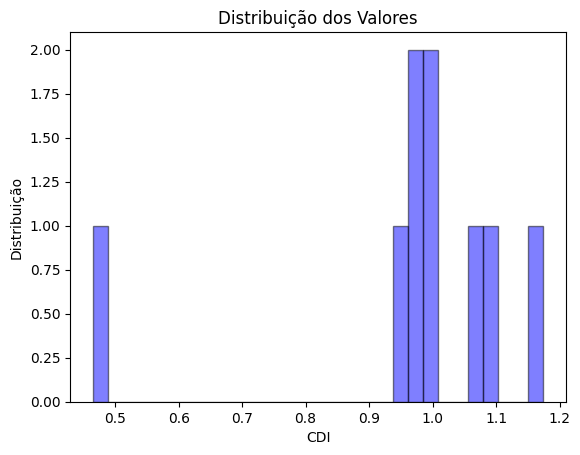

In [ ]:
# plotando a distribuição do cdi alcançado
import matplotlib.pyplot as plt
import numpy as np
data = cdi_array[1:]

# Criando o histograma
plt.hist(data, bins=30, alpha=0.5, color='blue', edgecolor='black')

# Adicionando títulos e labels
plt.title('Distribuição dos Valores')
plt.ylabel('Distribuição')
plt.xlabel('CDI')

# Mostrando o gráfico
plt.show()

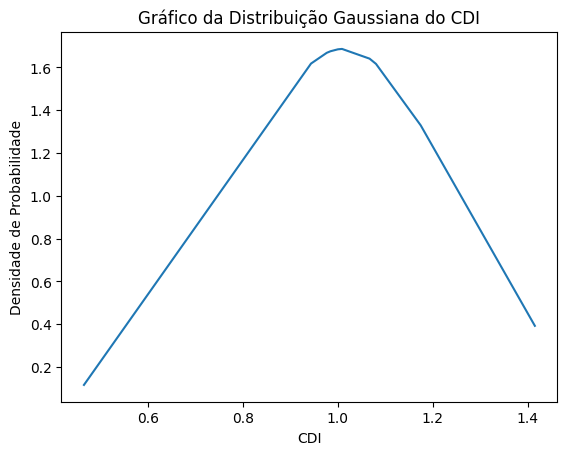

In [ ]:
# Gráfico da distribuição Gaussiana
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics

cdi_array.sort(reverse=True)
x_axis = cdi_array
mean = statistics.mean(x_axis)
sd = statistics.stdev(x_axis)

plt.plot(x_axis, norm.pdf(x_axis, mean, sd))

plt.title('Gráfico da Distribuição Gaussiana do CDI')  # Título do gráfico
plt.xlabel('CDI')  # Rótulo para o eixo X
plt.ylabel('Densidade de Probabilidade')  # Rótulo para o eixo Y
plt.show()
plt.show()

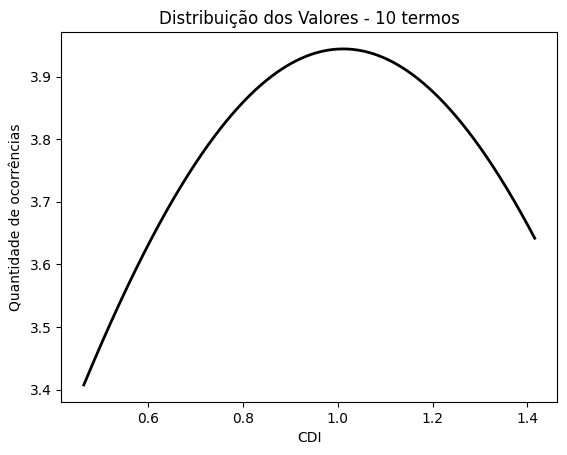

In [ ]:
# Ordena a lista de valores de forma decrescente
cdi_array.sort(reverse=True)
x_axis = cdi_array

# Calcula a média dos valores de CDI
mean = statistics.mean(x_axis)

# Gera uma lista de valores para o eixo X (CDI)
x_values = np.linspace(min(x_axis), max(x_axis), 1000)

# Calcula a densidade de probabilidade para a distribuição normal
p = norm.pdf(x_values, mean, mean)  # Usamos a média como o desvio padrão

# Multiplica a densidade de probabilidade pela quantidade total de ocorrências para obter a quantidade de ocorrências em cada ponto
quantidade_ocorrencias = p * len(x_axis)

# Plotando a curva de distribuição
plt.plot(x_values, quantidade_ocorrencias, 'k', linewidth=2)

# Adicionando títulos e labels
plt.title('Distribuição dos Valores - 10 termos')
plt.ylabel('Quantidade de ocorrências')
plt.xlabel('CDI')

# Exibindo o gráfico
plt.show()